In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
import librosa
import torch
from pathlib import Path
from Models.vae import VAE
from datasets import WaveformDataset,SpectrogramDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
file_path = Path("/net/projects/scratch/summer/valid_until_31_January_2024/ybrima/data/learning/SyncSpeech/dataset.npz")
# Load data
data = np.load(file_path, allow_pickle=True)
x = data['x']
y = data['y']
metadata = data['metadata'].tolist()
CLASSES = data['classes']

In [3]:
sample_rate = 44100
idx = np.random.randint(len(x))
print(f"Label: {CLASSES[y[idx]]}, Frequency = {metadata['freqs'][idx]} Hz, Amplitude = {metadata['amps'][idx]}")
Audio(x[idx], rate=sample_rate)

Label: triangle, Frequency = 21395.151515151516 Hz, Amplitude = 0.6684210526315789


In [6]:
train_dataset = WaveformDataset(x, y)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [7]:
latent_dim = 16
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = VAE(latent_dim).to(device)
state_dict = torch.load('./Exports/vae.pth')

# Load state dict
vae.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
x_batch, y_batch  = next(iter(train_loader))
with torch.inference_mode():
  z_mean, z_logvar = vae.encode(x_batch.to(device))
  z = vae.reparameterize(z_mean, z_logvar)
  x_hat = vae.decode(z)

In [9]:
idx =  np.random.randint(len(x_hat))
Audio(x_hat[idx].squeeze().detach().cpu(), rate=sample_rate)

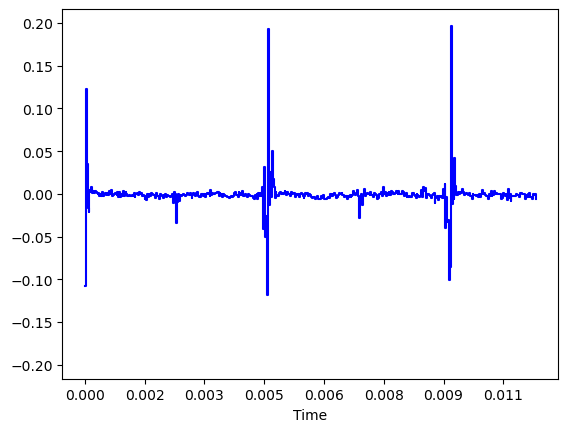

In [11]:
librosa.display.waveshow(x_hat[idx].squeeze().detach().cpu().numpy()[:500], sr=sample_rate, color='b' )

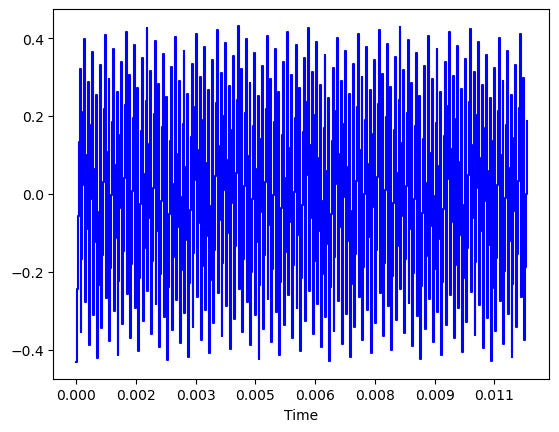

In [12]:
librosa.display.waveshow(x_batch[idx].squeeze().detach().cpu().numpy()[:500], sr=sample_rate, color='b')

In [13]:
print(f"Playing {CLASSES[y_batch[idx]]}")
Audio(x_batch[idx].squeeze().cpu(), rate=sample_rate)

Playing sawtooth


In [14]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_sounds = vae.decode(latent_samples)  # Decode the latent samples


In [15]:
idx =  np.random.randint(len(generated_sounds))
Audio(generated_sounds[idx].squeeze().detach().cpu(), rate=sample_rate)

In [19]:
data = np.load(file_path, allow_pickle=True)
x = data['x']
y = data['y']

# Split data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Create dataset
train_dataset = SpectrogramDataset(x_train, y_train)
val_dataset = SpectrogramDataset(x_val, y_val)
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

(torch.Size([64, 1, 44100]), torch.Size([64, 1, 513, 173]))

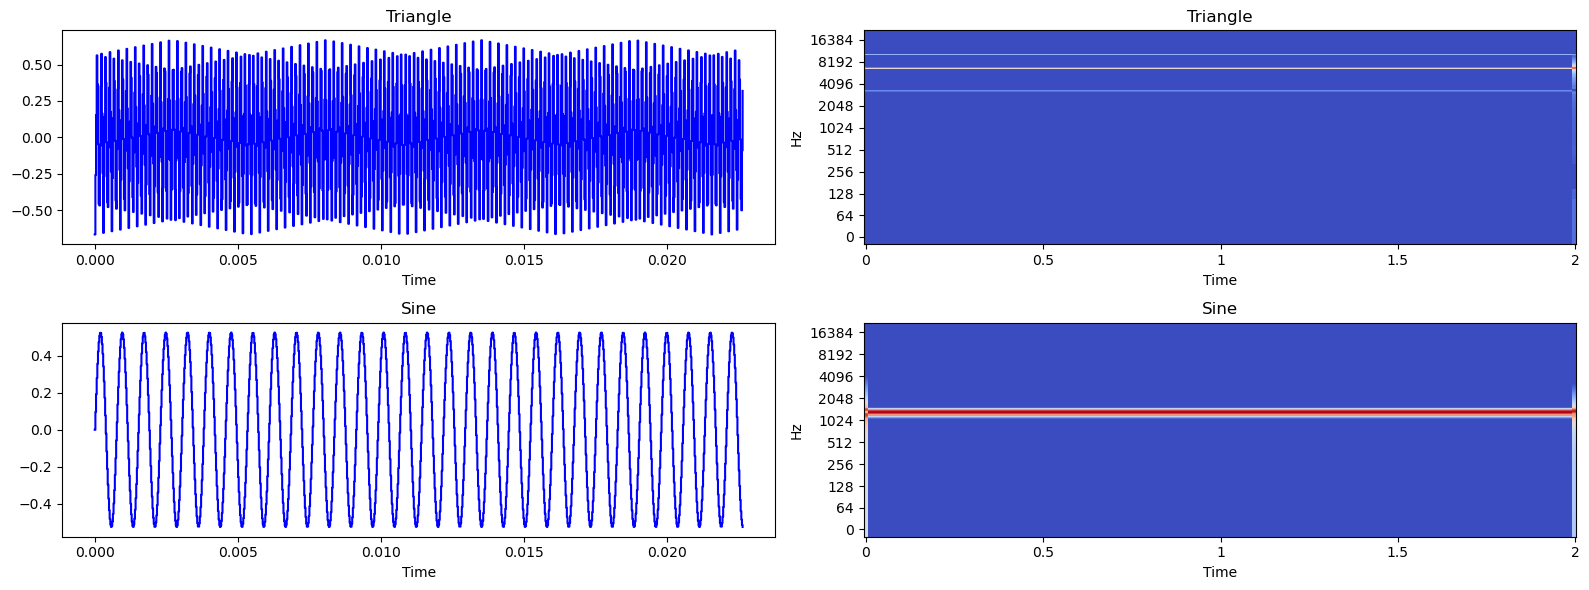

In [76]:
x_batch,spec_batch, y_batch = next(iter(train_loader))
n = 2
idx = np.random.randint(len(x_batch), size=n)
# Plot
fig, axs = plt.subplots(n, 2, figsize=(16,6))

for i in range(n):
  # Waveform 
  librosa.display.waveshow(x_batch[idx[i]].squeeze().detach().cpu().numpy()[:1000], sr=sample_rate, color='b', ax=axs[i, 0])
  # axs[i, 0].plot(x_batch[i].squeeze().detach().cpu().numpy())
  axs[i, 0].set_title(f'{CLASSES[y_batch[idx[i]]].capitalize() }')
  axs[i, 0].set_xlabel('Time')
  axs[i, 0].set_ylabel('Amplitude')

  # Spectrogram
  # axs[i, 1].imshow(librosa.power_to_db(spec_batch[idx[i]].squeeze().detach().cpu().numpy()), origin="lower", aspect="auto", interpolation="nearest")
  librosa.display.specshow(librosa.amplitude_to_db(spec_batch[idx[i]].squeeze().detach().cpu().numpy()),win_length=512, sr=sample_rate, x_axis='time', y_axis='log', ax=axs[i, 1])
  axs[i, 1].set_title(f'{CLASSES[y_batch[idx[i]]].capitalize() }')
  axs[i, 1].set_xlabel('Time')
  axs[i, 1].set_ylabel('Frequency')
plt.tight_layout()
# save the figure
plt.savefig('./Figures/Samples.png', dpi=300)
plt.show()

In [105]:
# plt.rcParams.update({
#     'figure.facecolor': 'white',
#     'axes.facecolor': 'white', 
#     'axes.edgecolor': 'white',
#     'axes.labelcolor': 'white',
#     'xtick.color': 'white',
#     'ytick.color': 'white',
#     'text.color': 'white',
#     'savefig.facecolor': 'white',
#     'savefig.edgecolor': 'white'
# })

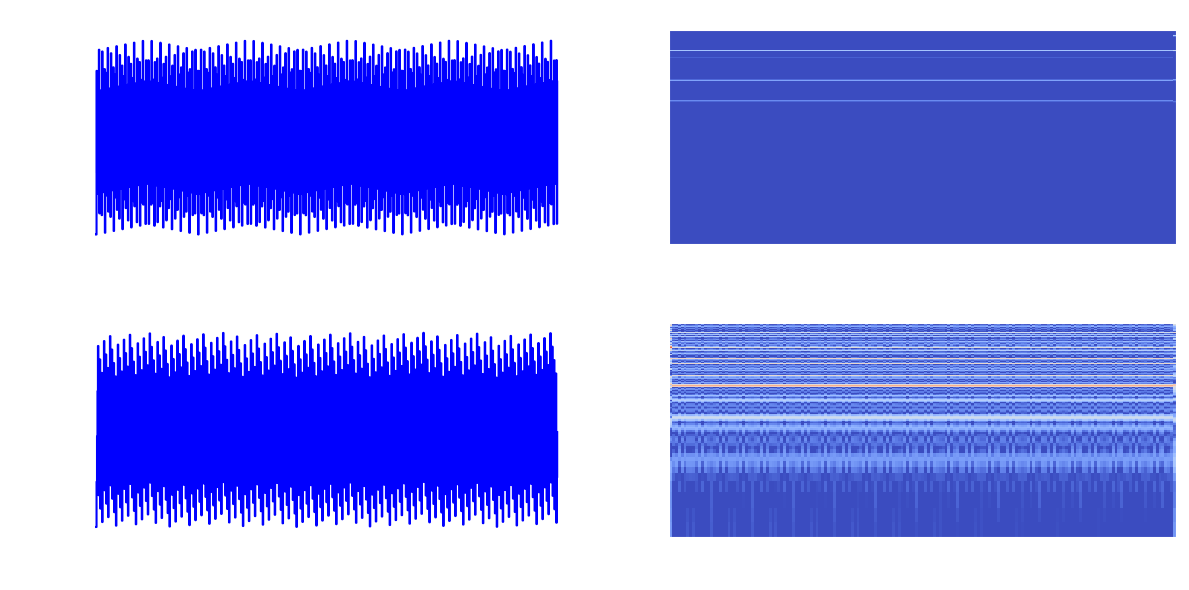

In [104]:
x_batch,spec_batch, y_batch = next(iter(train_loader))
n = 2
idx = np.random.randint(len(x_batch), size=n)
# Plot
fig, axs = plt.subplots(n, 2, figsize=(12,6))
# fig.patch.set_facecolor('none') 
for i in range(n):
  # Waveform 
  librosa.display.waveshow(x_batch[idx[i]].squeeze().detach().cpu().numpy()[:1000], sr=sample_rate, color='b', ax=axs[i, 0])
  # axs[i, 0].plot(x_batch[i].squeeze().detach().cpu().numpy())
  axs[i, 0].set_title(f'{CLASSES[y_batch[idx[i]]].capitalize() }')
  axs[i, 0].set_xlabel('Time')
  axs[i, 0].set_ylabel('Amplitude')

  # Spectrogram
  # axs[i, 1].imshow(librosa.power_to_db(spec_batch[idx[i]].squeeze().detach().cpu().numpy()), origin="lower", aspect="auto", interpolation="nearest")
  librosa.display.specshow(librosa.amplitude_to_db(spec_batch[idx[i]].squeeze().detach().cpu().numpy()),win_length=512, sr=sample_rate, x_axis='time', y_axis='log', ax=axs[i, 1])
  axs[i, 1].set_title(f'{CLASSES[y_batch[idx[i]]].capitalize() }')
  axs[i, 1].set_xlabel('Time')
  axs[i, 1].set_ylabel('Frequency')
plt.tight_layout()
# save the figure
plt.savefig('./Figures/Samples2.png', dpi=300, transparent=True)
plt.show()

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2,return_indices=True)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2,return_indices=True)
        
        self.fc_enc1 = nn.Linear(32 * 128 * 43, 64)
        self.fc_enc2_mean = nn.Linear(64, latent_dim)
        self.fc_enc2_logvar = nn.Linear(64, latent_dim)
        
        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, 64)
        self.fc_dec2 = nn.Linear(64, 32 * 128 * 43)
        
        self.unpool2 = nn.MaxUnpool2d(2,return_indices=True)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.unpool1 = nn.MaxUnpool2d(2,return_indices=True)
        self.deconv1 = nn.ConvTranspose2d(16, 1, kernel_size=5, padding=2)
        
        # Non-linearity
        self.neg_factor = 0.01
        
    def encode(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=self.neg_factor)
        x = self.pool1(x)
        x = F.leaky_relu(self.conv2(x), negative_slope=self.neg_factor)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        
        x = F.leaky_relu(self.fc_enc1(x), negative_slope=self.neg_factor)
        z_mean = self.fc_enc2_mean(x)
        z_logvar = self.fc_enc2_logvar(x)
        return z_mean, z_logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        z = F.leaky_relu(self.fc_dec1(z), negative_slope=self.neg_factor)
        z = F.leaky_relu(self.fc_dec2(z), negative_slope=self.neg_factor)
        z = z.view(-1, 32, 128, 43)
        
        z = self.unpool2(z)
        z = F.leaky_relu(self.deconv2(z), negative_slope=self.neg_factor)
        z = self.unpool1(z)
        x_hat = torch.tanh(self.deconv1(z))
        return x_hat
    
    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_hat = self.decode(z)
        return x_hat, z_mean, z_logvar

In [129]:
# Generate random of size torch.Size([64, 1, 513, 173])
X  = torch.randn(1, 1, 513, 173)
7500
cvae = CVAE(latent_dim).to(device)
x_hat, z_mean, z_logvar = cvae(X.to(device))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


torch.Size([1, 1, 512, 172])